### Validate Model Using ModelStats


We'll use the property crime model you've been working on with, based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include other states crime rates in 2013 or crime rates in New York State in other years or a combination of these.
Submit a notebook with your model and a brief writeup of your feature engineering and selection process to submit and review with your mentor.

Iterate
Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.

Include your model(s) and a brief writeup of the reasoning behind the validation method you chose and the changes you made to submit and review with your mentor.

### Steps and questions:
1. Model using sklearn (to get fit and output score r-squared)
2. Model using statsmodels to get the parameter p-values
Question1: Is it necessary to use both ML libraries? How can I cross-validate a statsmodels model ols model using r-squared as an indicator?
Question2: How do I run a F-test of my model?
3. Cross-validate using Kfolds on the 2013 and 2014 dataset
4. Change the model to remove insignificant parameters
5. Re-run the CV

In [226]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import numpy as np


In [227]:
# import 2013 data to train model
#import the crime raw crime data for 2013 without headers/footers and replace null values with zeroes
crime_raw_2013 = pd.read_csv(filepath_or_buffer='table_8_offenses_no_header_footer.csv', delimiter=',')

#remove NYC as an outlier (per previous linear regression model on 2013 data)
crime_raw_2013 = crime_raw_2013[crime_raw_2013.City != 'New York']
column_list = list(crime_raw_2013.columns.values)
print(column_list)
print(len(crime_raw_2013))




['City', 'Population', 'Violent_Crime', 'Murder_and_Manslaughter', 'Rape', 'Robbery', 'Aggravated_assault', 'Property_crime', 'Burglary', 'Larceny_theft', 'vehicle_theft', 'Arson']
347


In [228]:
# Create a features dataframe that converts values to floats from strings, creates categorical values for murder and robbery 
# and creates a populations squared feature

crime_raw_2013['Robbery']= crime_raw_2013['Robbery'].str.replace(",","").astype(float)
crime_raw_2013['Property_crime']= crime_raw_2013['Property_crime'].str.replace(",","").astype(float)

crime_features = pd.DataFrame()
crime_features['population'] = crime_raw_2013['Population'].str.replace(",","").astype(float)
crime_features['population_squared'] = crime_features['population'] ** 2
crime_features['murder'] = np.where(crime_raw_2013['Murder_and_Manslaughter'] > 0, 1,0)
#crime_features['robbery'] = np.where(crime_raw_2013['Robbery'] > 0, 1,0)

crime_features.dropna(inplace=True)

crime_features.head()

,population,population_squared,murder
0,1861.000,3463321.000,0
1,2577.000,6640929.000,0
2,2846.000,8099716.000,0
3,97956.000,9595377936.000,1
4,6388.000,40806544.000,0


In [229]:
# fit data using sklearn ols

from sklearn import linear_model
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

#Property_crime=α+Population+Population2+Murder+Robbery
# try original model with outliers
# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(crime_features, crime_raw_2013['Property_crime'])


# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(crime_features, crime_raw_2013['Property_crime']))


Coefficients: 
 [  1.44802892e-02   1.08747761e-07   2.06933253e+02]

Intercept: 
 18.8619916526

R-squared:
0.843013263732


#### Re-created previous model using sklearn linear regression. Will next use statsmodels to output p-values for individual parameters 

In [230]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

crime_features_statsmodels = crime_features
crime_features_statsmodels['property_crime'] = crime_raw_2013['Property_crime']
# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'property_crime ~ population+population_squared+murder'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=crime_features_statsmodels).fit()
# coefficients for model
print("Coefficients for the model:")
print(lm.params,'\n')
# test significance for each coefficient
print("pvalues for the parameters:")
print(lm.pvalues, '\n')

# r-squared
print('r-squared value for model:')
print(lm.rsquared, '\n')

Coefficients for the model:
Intercept             18.862
population             0.014
population_squared     0.000
murder               206.933
dtype: float64 

pvalues for the parameters:
Intercept            0.533
population           0.000
population_squared   0.000
murder               0.007
dtype: float64 

r-squared value for model:
0.843013263732 



In [231]:

#import the crime raw crime data for ny for 2014
crime_raw_2014 = pd.read_csv(filepath_or_buffer='Crime_New_York_by_City_2014.csv', delimiter=',')
column_list_2014 = list(crime_raw_2014.columns.values)

#remove NYC
crime_raw_2014 = crime_raw_2014[crime_raw_2014.city != 'New York']
print(column_list_2014)

crime_raw_2014['robbery']= crime_raw_2014['robbery'].str.replace(",","").astype(float)
crime_raw_2014['property_crime']= crime_raw_2014['property_crime'].str.replace(",","").astype(float)


#crime_raw_2014.head()

#crime_raw_combined = crime_raw_2013.join(crime_raw_2014.set_index('city'), on='City')



['city', 'population', 'violent_crime', 'murder ', 'rape', 'robbery', 'aggravated_assault', 'property_crime', 'burglary', 'larceny_theft', 'vehicle_theft', 'arson']


In [232]:
crime_features_2014 = pd.DataFrame()
crime_raw_2014.dropna(inplace=True)


crime_features_2014['population'] = crime_raw_2014['population'].str.replace(",","").astype(float)
crime_features_2014['population_squared'] = crime_features_2014['population'] ** 2
crime_features_2014['murder'] = np.where(crime_raw_2014['murder '] > 0, 1,0)
#crime_features_2014['robbery'] = np.where(crime_raw_2014['robbery'] > 0, 1,0)



#create 2nd dataframe including target
#crime_features_2014_statsmodels = crime_features_2014
#crime_features_2014_statsmodels['property_crime'] = crime_raw_2014['property_crime']
crime_features_2014.head()


,population,population_squared,murder
2,820.000,672400.000,0
4,98595.000,9720974025.000,1
5,5872.000,34480384.000,0
6,1107.000,1225449.000,0
7,4032.000,16257024.000,1


In [233]:
#create predictions and get r2 
y_pred_2014 = regr.predict(crime_features_2014)
print(regr.score(crime_features_2014, crime_raw_2014['property_crime']))

0.703658983065


In [234]:
#identify number of folds and split the dataset
n = 3
crime_features_2014_split = np.array_split(crime_features_2014, n)
crime_target_2014 = crime_raw_2014['property_crime']
crime_target_2014_split = np.array_split(crime_target_2014, n)

#for each fold assign it as the test dataset and fit your model on the remaining data

for x in range(n):
    train_data = []
    train_target = []
   
    for y in range(n):
        if y == x :
            test_data = crime_features_2014_split[x]
            test_target = crime_target_2014_split[y]
        
            #print(\n, ' R-squared:')
            print(regr.score(test_data, test_target))

0.814009596692
0.680932032996
0.671549400812


C:\Users\stace\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


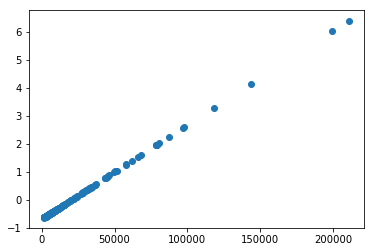

       Population  murder  Robbery  Property_crime  population_2014  \
count     190.000 190.000  190.000         190.000          190.000   
mean        0.000   0.000   -0.000          -0.000           -0.000   
std         1.003   1.003    1.003           1.003            1.003   
min        -0.639  -0.492   -0.261          -0.484           -0.640   
25%        -0.536  -0.492   -0.261          -0.418           -0.532   
50%        -0.379  -0.492   -0.237          -0.312           -0.381   
75%         0.237  -0.492   -0.144          -0.020            0.240   
max         6.400   2.034   10.735           9.252            6.363   

       murder_2014  robbery_2014  property_crime_2014  robbery  \
count      190.000       190.000              190.000  190.000   
mean         0.000        -0.000                0.000   -0.000   
std          1.003         1.003                1.003    1.003   
min         -0.475        -1.454               -0.495   -1.673   
25%         -0.475        -1.4

In [263]:
# try normalizing the features/target values to get more meaningful parameters
from sklearn import preprocessing

# create a features dataframe with both 2013 and 2014 data
df_crime_2013_final = crime_raw_2013.filter(['City','Population','Murder_and_Manslaughter','Robbery','Property_crime'], axis=1)
df_crime_2014_final = crime_raw_2014.filter(['city','population', 'murder ','robbery', 'property_crime'],axis=1)

df_crime_2014_final = df_crime_2014_final.rename(columns={'city':'City','population':'population_2014','murder ':'murder_2014','robbery':'robbery_2014','property_crime':'property_crime_2014'})
df_crime_2013_final = df_crime_2013_final.rename(columns={'Murder_and_Manslaughter':'murder'})

df_hash = pd.DataFrame()
df_crime_2013_final['City'] = df_crime_2013_final['City'].map(lambda x: x.replace(" ", ""))

df_crime_2014_final['City'] = df_crime_2014_final['City'].map(lambda x: x.replace(" ", ""))

#df_crime_2013['City_2013'] = df_crime_2013_final['City'].strip()

#df_crime_2014_final.head(n=50)




#df_combined = df_crime_2013_final.set_index('City').join(df_crime_2014_final.set_index('City'))
df_combined = df_crime_2013_final.merge(df_crime_2014_final)
#df_combined['Property_crime']= df_combined['Property_crime'].str.replace(",","").astype(float)
#df_combined['property_crime_2014']= df_combined['property_crime_2014'].str.replace(",","").astype(float)
df_combined['population_2014'] = df_combined['population_2014'].str.replace(",","").astype(float)
df_combined['Population'] = df_combined['Population'].str.replace(",","").astype(float)
df_combined['murder'] = np.where(df_combined['murder'] > 0, 1,0)
df_combined['robbery'] = np.where(df_combined['Robbery'] > 0, 1,0)

df_combined['murder_2014'] = np.where(df_combined['murder_2014'] > 0, 1,0)
df_combined['robbery_2014'] = np.where(df_combined['robbery_2014'] > 0, 1,0)

#df_combined.head()



# Select only numeric variables to scale.
df_num = df_combined.select_dtypes(include=[np.number]).dropna()
df_num['population_squared'] = df_num['Population'] ** 2
df_num['population_2014_squared'] = df_num['population_2014'] ** 2

#Save the column names.
names=df_num.columns

# Scale, then turn the resulting numpy array back into a data frame with the
# correct column names.
df_scaled = pd.DataFrame(preprocessing.scale(df_num), columns=names)
# The new features contain all the information of the old ones, but on a new scale.
plt.scatter(df_num['Population'], df_scaled['Population'])
plt.show()

# Lookit all those matching means and standard deviations!
print(df_scaled.describe())



In [279]:
# separate the 2013 and 2014 data and targets again
features_scaled_2013 = df_scaled.filter(['Population','murder','Robbery','population_squared'], axis=1)
target_scaled_2013 = df_scaled.filter(['Property_crime'], axis=1)

features_scaled_2014 = df_scaled.filter(['population_2014','murder_2014','robbery_2014','population_2014_squared'], axis=1)
features_scaled_2014 = features_scaled_2014.rename(columns={'population_2014':'Population','population_2014_squared':'population_squared','murder_2014':'murder','robbery_2014':'Robbery'})

target_scaled_2014 = df_scaled.filter(['property_crime_2014'], axis=1)
target_scaled_2014 = target_scaled_2014.rename(columns={'property_crime_2014':'Property_crime'})
target_scaled_2014.head()

,Property_crime
0,3.643
1,-0.289
2,-0.474
3,1.699
4,-0.491


In [277]:
#Property_crime=α+Population+Population2+Murder+Robbery
# try original model with outliers
# Instantiate our model.
regr_scaled = linear_model.LinearRegression()

# Fit our model to our data.
regr_scaled.fit(features_scaled_2013, target_scaled_2013)


# Inspect the results.
print('\nCoefficients: \n', regr_scaled.coef_)
print('\nIntercept: \n', regr_scaled.intercept_)
print('\nR-squared:')
print(regr_scaled.score(features_scaled_2013, target_scaled_2013))




Coefficients: 
 [[ 0.7024516  -0.03862829  0.87594872 -0.574428  ]]

Intercept: 
 [ -1.50263770e-17]

R-squared:
0.90228026873


In [280]:
#create predictions for 2014 and get r2 
y_pred_2014_scaled = regr_scaled.predict(features_scaled_2014)
print(regr_scaled.score(features_scaled_2014, target_scaled_2014))



-0.309583858973
